# Contributor Risk Analysis

Learn whether you have enough contributors to sustain the project if a key contributor won the lottery and retired on a beach.

You can also use this data to identify contributors who might be good candidates for mentoring to expand their contributions or help them move into leadership roles.

All the notebooks in this folder are based on https://github.com/chaoss/augur-community-reports templates. 

In [1]:
import psycopg2
import pandas as pd 
import sqlalchemy as salc
import json
import warnings
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import textwrap
from datetime import datetime, timezone

In [2]:
with open("../../config_temp.json") as config_file:
    config = json.load(config_file)
    
database_connection_string = 'postgresql+psycopg2://{}:{}@{}:{}/{}'.format(config['user'], config['password'], config['host'], config['port'], config['database'])

dbschema='augur_data'
engine = salc.create_engine(
    database_connection_string,
    connect_args={'options': '-csearch_path={}'.format(dbschema)})

## Control Cell - Set Variables and Filters 

The cell below is for generating repo_ids from the repo names. For this to work, the repo must already be in the database. If you want to manually assign a repo_id skip the cell below and read the comments on the next cell.

In [3]:
#add your repo name here of the repo you want to query if known (and in the database)
repo_name = 'augur'

repo_query = salc.sql.text(f"""
             SET SCHEMA 'augur_data';
             SELECT 
                b.repo_id
            FROM
                repo_groups a,
                repo b
            WHERE
                a.repo_group_id = b.repo_group_id AND
                b.repo_name = \'{repo_name}\'
    """)

t = engine.execute(repo_query)
repo_id =t.mappings().all()[0].get('repo_id')
print(repo_id)

25440


In [4]:
#Take this out of quotes if you want to manually assign a repo_id number
#repo_id = 25440

# Thresholds for how many contributors you think should make up a certain percent of the commits
# The default is that a healthy project will have at least 3 contributors combined who are 
# making no more than 70% of the commits.
# For smaller projects, you might set this at 2 contributors. 
# For larger projects, you might want 5 contributors making no more than 50% of the commits.
num_contrib = 3
max_percent = .70

#specify dates for filtering - a typical default would be one year of data
#if the end_date is in the future, the end_date will default to the current_date
begin_date = '2020-06-01'
end_date = '2021-07-31'

## Gathering and Processing the Data into a dataframe

**Important note: You may need to edit this query to exclude additional bots with unexpected names.**

In [5]:
#Commit data - from humans excluding known bots
commitsDF = pd.DataFrame()
commitsquery = f"""
                SET SCHEMA 'augur_data';
                SELECT
                    DISTINCT(cmt_commit_hash),
                    contributors.cntrb_canonical,
                    canonical_full_names.cntrb_full_name AS canonical_full_name,
                    cmt_author_name, cmt_author_email, repo_id, cmt_author_timestamp 
                FROM commits 
                    LEFT OUTER JOIN contributors ON cntrb_email = cmt_author_email left outer join 
                    (
                        SELECT distinct on (cntrb_canonical) cntrb_full_name, cntrb_canonical, data_collection_date
                        FROM contributors
                        WHERE cntrb_canonical = cntrb_email
                        order by cntrb_canonical
                    ) canonical_full_names on canonical_full_names.cntrb_canonical = contributors.cntrb_canonical
                WHERE 
                    repo_id = {repo_id}
                    AND cmt_author_name NOT LIKE '%%bot'
                    AND cmt_author_name NOT LIKE '%%Bot'
                    AND cmt_author_name NOT LIKE '%%BOT'
                    AND cmt_author_name NOT LIKE 'dependabot%%'
                    AND cmt_author_name NOT LIKE 'gerrit%%'
                    AND cmt_author_name NOT LIKE '%%utomation%%'
                    AND cmt_author_name NOT LIKE '%%ipeline%%'
                ORDER BY
                    cntrb_canonical;
                """

end_dt = datetime.strptime(end_date, '%Y-%m-%d').replace(tzinfo=timezone.utc)
begin_dt = datetime.strptime(begin_date, '%Y-%m-%d').replace(tzinfo=timezone.utc)

all_commitsDF = pd.read_sql_query(commitsquery, con=engine)
commitsDF = all_commitsDF[(all_commitsDF['cmt_author_timestamp'] >= begin_dt) & (all_commitsDF['cmt_author_timestamp'] <= end_dt)]
total_commits = commitsDF.cmt_commit_hash.nunique()   

dedupDF = commitsDF.drop_duplicates(subset=['cmt_commit_hash'], inplace = False, keep="first")

authorDF = pd.DataFrame()
authorDF = dedupDF.canonical_full_name.value_counts()
authorDF = authorDF.reset_index()
authorDF.columns = ['name', 'commits']
authorDF['percent'] = authorDF['commits'] / total_commits

# The repo_name is only used to add to the title of the graph.
get_repo_name_query = f"""
    SELECT repo_name from repo where repo_id = {repo_id};
       """
get_repo_name = pd.read_sql_query(get_repo_name_query, con=engine)
repo_name = get_repo_name.repo_name[0]

## Calculating Contributor Risk and Adding Analysis to the Title

In [6]:
cum_percent = 0
people_list = []

i = 1
num_people = 0

for item in authorDF.iterrows():
    name = item[1]['name']
    percent = item[1]['percent']
    commits = item[1]['commits']

    cum_percent += percent

    people_list.append([name, percent, commits])

    if (cum_percent > max_percent and num_people == 0):
        num_people = i
        risk_percent = cum_percent

    if i == 8:
        if cum_percent <= max_percent:
            risk_percent = cum_percent
            num_people = i
        break
    i+=1

risk_list = []
bar_colors = []

j = 1
for person in people_list:
    name = person[0]
    if len(name) > 15:
        new_name = textwrap.wrap(name, 15)
        name = '\n'.join(new_name)
    percent = person[1]
    commits = person[2]
    risk_list.append([name, percent, commits])

    if (num_people < num_contrib and j <= num_people):
        bar_colors.append('red')
    else:
        bar_colors.append('lightblue')

    j+=1

names = [item[0] for item in risk_list]
percents = [item[1] for item in risk_list]
commits = [item[2] for item in risk_list]

title = repo_name + "\nContributor Risk: "

if num_people < num_contrib:
    risk = 'AT RISK'
    title += "AT RISK"
    title_color = 'firebrick'
else:
    risk = 'HEALTHY'
    title += "Healthy"
    title_color = 'forestgreen'

title += "\n" + str(num_people) + " people made up " + "{:.0%}".format(risk_percent) + " of the commits from " + begin_date + " to " + end_date + ".\n"

max_perc_str = "{:.0%}".format(max_percent)
interpretation = 'Interpretation: Healthy projects should have at minimum ' + str(num_contrib) + ' people who combined account for the majority (>' + max_perc_str + ') of the commits.\nThe higher this number is, the more likely your project would succeed if a leading contributor suddenly left the project.\nRed bars indicate when less than ' + str(num_contrib) + ' people made ' + max_perc_str + ' of the commits. Light blue for other contributors.'


## Plotting the Results

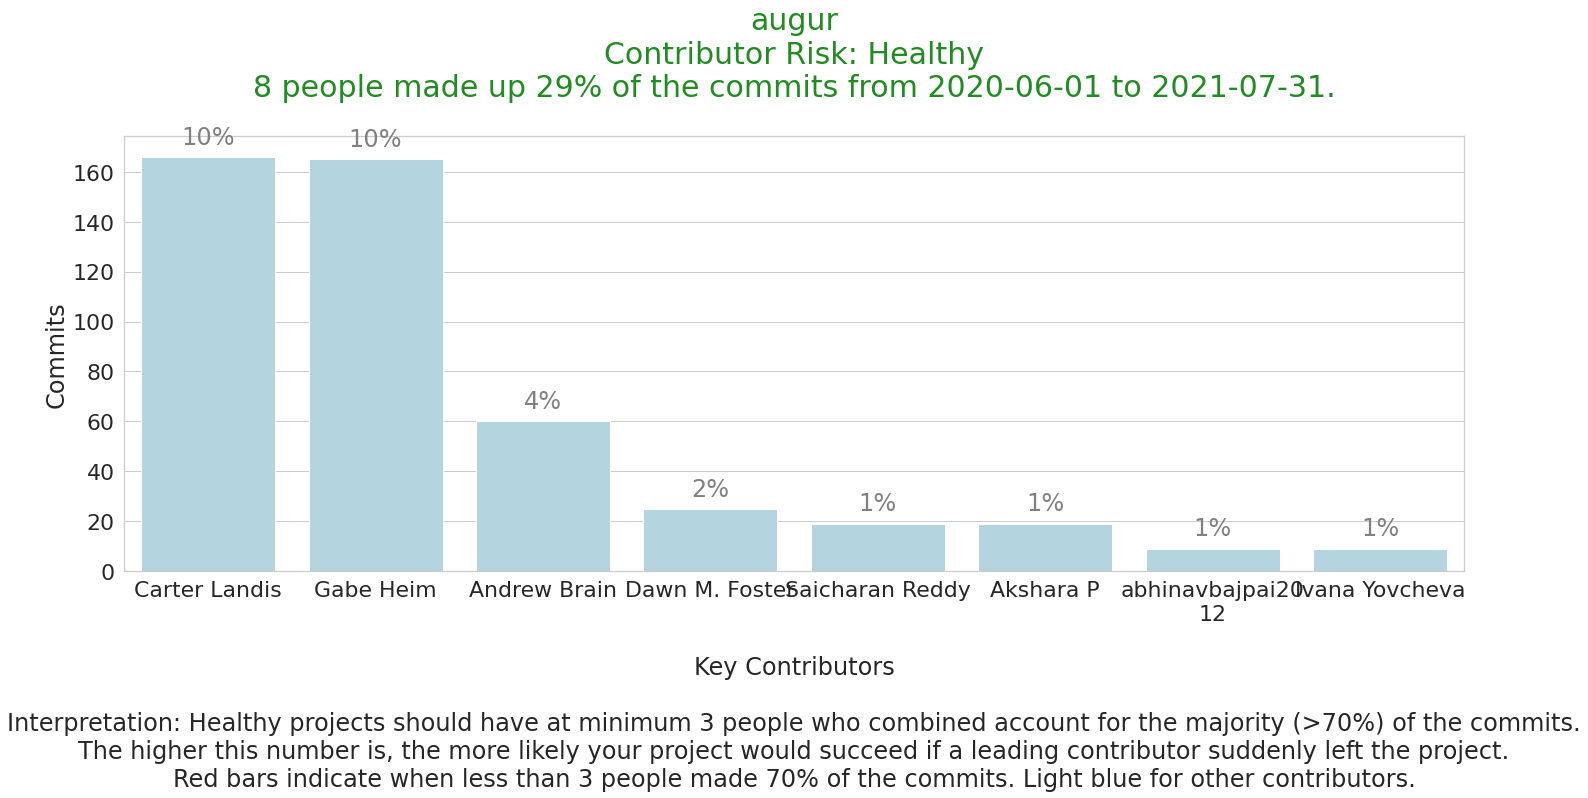

In [7]:
sns.set_style('ticks')
sns.set(style="whitegrid", font_scale=2)

fig, ax = plt.subplots()

# the size of A4 paper
fig.set_size_inches(24, 8)

risk_bar = sns.barplot(x=names, y=commits, palette=bar_colors).set_title(title, fontsize=30, color=title_color)

risk_bar_labels = ax.set_xticklabels(names, wrap=True)
risk_bar_labels = ax.set_ylabel('Commits')
xlabel_str = '\nKey Contributors\n\n' + interpretation
risk_bar_labels = ax.set_xlabel(xlabel_str)

i = 0
for p in ax.patches:
    ax.annotate("{:.0%}".format(percents[i]), (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='center', color='gray', xytext=(0, 20),
        textcoords='offset points')
    i+=1
